# Predicción de Admisión de Estudiantes con Redes Neuronales usando Keras

Este ejercicio está inspirado en el Nanodegree de Inteligencia Artificial de Udacity. El objetivo es predecir si aceptamos a un estudiante a graduate studies (maestría, doctorado, etc) a UCLA basándonos en 3 datos:
* GRE Scores (Es un examen estandar en todo Estados Unidos).
* GPA Scores (Promedio de la carrera, suele ir de 1 a 4).
* Class Rank (El rango de la clase, es de 1 a 4).

El dataset lo puedes encontrar en: http://www.ats.ucla.edu/

## Paso 1. Cargar la información

Para poder cargar y manipular la información, vamos a utilizar Pandas y Numpy, dos librerías **muy** comunes en Data Science, Machine Learning y Deep Learning

In [33]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [34]:
# Importamos Pandas y NumPy
import pandas as pd
import numpy as np

# Leemos el archivo csv (comma separated values)
data = pd.read_csv('/content/students-data.csv')

# Imprimimos los primeros 10 resultados
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


** Pregunta 1. ¿Cuál sería(n) los features en este problema? ¿Cómo están relacionados con el valor que queremos predecir?**

(Puedes dar click en esta celda y escribir tus respuestas).

## Paso 2. Comprender la información.

Una de las maneras más fáciles de entender la información es mediante visualizaciones. Lee los comentarios de la siguiente celda para entender qué está ocurriendo.

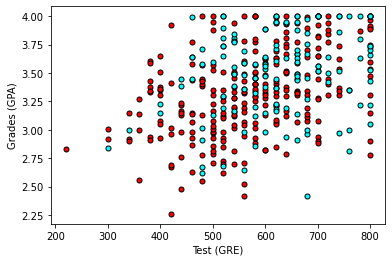

In [35]:
# Importamos matplotlib
import matplotlib.pyplot as plt

# Función que hace el plot
def plot_points(data):
    
    # Vamos a cargar los dos features numéricos de este problema: GRE y GPA. Lo cargamos como un arreglo de NumPy.
    X = np.array(data[["gre","gpa"]])
    
    # También cargamos el valor que queremos predecir.
    y = np.array(data["admit"])
    
    # Separamos los features según fue aceptado o rechazado
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    
    # Hacemos un scatter plot, donde el color rojo es rechazado y los celestes son aceptados.
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Mostramos los puntos
plot_points(data)
plt.show()

Aunque no hay una relación tan clara, se puede decir que los estudiantes con mejores promedios y calificaciones en el examen son más probables de ser aceptados. De todos modos, la información no se puede separar tan fácil como en otros problemas que hemos enfrentado. Tal vez si usamos el tercer feature, el Rank, se separe mejor la información. Vamos a hacer 4 gráficas como la anterior, una para cada promedio.

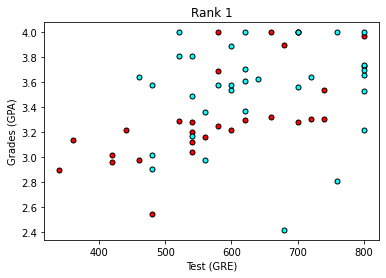

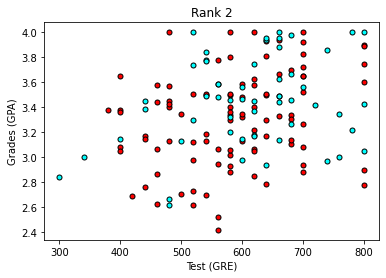

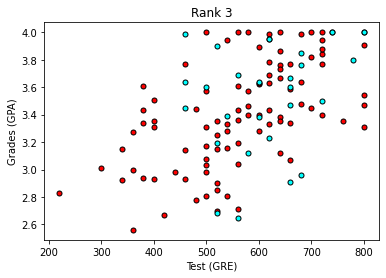

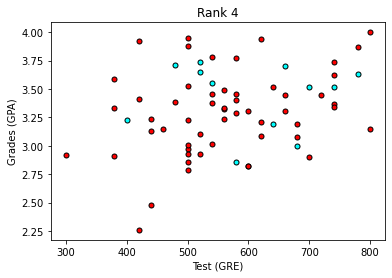

In [36]:
# Separamos el rank
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Mostramos los gráficos para cada uno
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()

plot_points(data_rank2)
plt.title("Rank 2")
plt.show()

plot_points(data_rank3)
plt.title("Rank 3")
plt.show()

plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

Esto se entiende mejor. Mientras el rango tiene un valor más bajo (mejor rango), parece que es más probable que seas aceptado. Vamos a utilizar el rango, entonces, como uno de nuestros features, pero, para poder hacerlo, necesitamos hacer algo llamado one-hot encoding.

## Paso 3: Modificamos la información para la red neuronal

### One-hot encoding

Pandas ya tiene herramientas para hacer esto, por lo que vamos a aprovecharlas. No te preocupes mucho por el código, intenta enfocarte en lo que está ocurriendo. 

La función get_dummies va a separar variables categóricas en muchas variables. Por ejemplo:

In [37]:
pd.get_dummies(data['rank'], prefix='rank')[:5]

,rank_1,rank_2,rank_3,rank_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


Ahora que sabemos cómo conseguir esas columnas, las podemos agregar a nuestro dataset.

In [38]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)
one_hot_data[:5]

,admit,gre,gpa,rank,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,3,0,0,1,0
1,1,660,3.67,3,0,0,1,0
2,1,800,4.00,1,1,0,0,0
3,1,640,3.19,4,0,0,0,1
4,0,520,2.93,4,0,0,0,1


Pero ahora tenemos una columna que no nos interesa, rank. Podemos eliminar esa columna

In [39]:
# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


### Escalando datos

Todo se ve bien, pero tenemos un problema. El GRE parece ir de 200 a 800, mientras que el GPA va de 1 a 4. El rango en el GRE es mucho más grande y esto puede causar problemas. En la siguiente celda vamos a escalar la información para que los features estén entre 0 y 1.

In [40]:
# Copiamos la información
processed_data = one_hot_data[:]
#print(processed_data.shape)
# o len(dataset)
# Escalamos ambas columnas
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:5]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


### Separar los datos en Training y Testing Set

** Pregunta 2. ¿Por qué tenemos que separar en Training y Testing Set?**

En la siguiente celda separaremos en training y testing set. El testing set será el 10% de nuestra info total. No se preocupen mucho por el código, pero entiendan qué está pasando. Si corres la siguiente celda muchas veces, los resultados serán diferentes. Lo que estamos haciendo es agarrar el 90% de los datos utilizando ```np.random.choice```. Especificamos que no usamos remplazo (cuando sacamos un valor, no lo ponemos de vuelta). En la segunda línea lo que hacemos es agarrar los elementos y soltarlos (para el training y para el testing, respectivamente).

In [41]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("El número de training samples es", len(train_data))
print("El número de testing samples es", len(test_data))
print(train_data[:7])
print(test_data[:7])

El número de training samples es 360
El número de testing samples es 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
182      0  0.875  1.0000       0       1       0       0
129      0  0.575  0.7875       0       0       0       1
42       1  0.750  0.7875       0       1       0       0
249      0  0.800  0.9325       0       0       1       0
152      1  0.800  0.9850       0       1       0       0
197      1  0.500  0.8075       0       0       0       1
259      0  0.800  0.9525       0       1       0       0
    admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
14      1  0.875  1.0000       1       0       0       0
15      0  0.600  0.8600       0       0       1       0
17      0  0.450  0.6400       0       0       1       0
22      0  0.750  0.7050       0       0       0       1
25      1  1.000  0.9150       1       0       0       0
26      1  0.775  0.9025       1       0       0       0
52      0  0.925  0.8425       0       0       0       1


### Separar data en features y labels

**Pregunta 3. ¿Cuál es la diferencia entre features y labels?**

Si te sale un error en la siguiente celda asegúrate de tener Keras instalado en tu ambiente.

In [42]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Separar data y hacer one-hot encoding de la salida (aceptado o rechazado)
# Nota: Adicionalmente, estamos convirtiendo todo a np.array para que Keras lo pueda utilizar.

# Soltamos la columna de admit en los features
features = np.array(train_data.drop('admit', axis=1))

# Primero convertimos admit en dos columnas (one-hot encoding) usando la función to_categorical de Keras. 
# Esta es la que se usa normalmente para hacer one-hot encoding.
targets = np.array(tf.keras.utils.to_categorical(train_data['admit'], 2))

# Hacemos lo mismo para el testing set
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(tf.keras.utils.to_categorical(test_data['admit'], 2))

print(features[:5])
print(targets[:5])

[[0.875  1.     0.     1.     0.     0.    ]
 [0.575  0.7875 0.     0.     0.     1.    ]
 [0.75   0.7875 0.     1.     0.     0.    ]
 [0.8    0.9325 0.     0.     1.     0.    ]
 [0.8    0.985  0.     1.     0.     0.    ]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


## Paso 4. Construimos Arquitectura del Modelo

In [43]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

# Construimos el modelo
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(6,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))
# Softmax en la ultima capa, nos arroja una probabilidad de pertenencia para c/u de las clases

# Compilamos el modelo
model.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
#BinaryCrossEntropy, Optimezer Adam
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               896       
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                                 
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________


## Paso 5. Entrenamos el modelo

In [46]:
model.fit(features, targets, epochs=200, batch_size=100, verbose=1)

Epoch 1/200
4/4 [==============================] - 0s 9ms/step - loss: 0.2268 - accuracy: 0.6667
Epoch 2/200
4/4 [==============================] - 0s 8ms/step - loss: 0.2264 - accuracy: 0.6639
Epoch 3/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2273 - accuracy: 0.6722
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2211 - accuracy: 0.6778
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2293 - accuracy: 0.6694
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2258 - accuracy: 0.6694
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2284 - accuracy: 0.6611
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2267 - accuracy: 0.6750
Epoch 9/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2302 - accuracy: 0.6722
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2281 - accuracy: 0.6639
Epoch 11/200
4/4 [===========

## Paso 6. Evaluamos el modelo

In [45]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

12/12 [==============================] - 0s 3ms/step - loss: 0.2188 - accuracy: 0.6778

 Training Accuracy: 0.6777777671813965
2/2 [==============================] - 0s 7ms/step - loss: 0.2017 - accuracy: 0.7250

 Testing Accuracy: 0.7250000238418579


## Reto. Juega con los parámetros

Como puedes ver, hemos hecho muchas decisiones para entrenar nuestro modelo. Por ejemplo: número de capas, tamaño de capas, número de epochs y más. Ahora te toca a ti cambiar los paráemtros y ver si puedes mejorar la precisión en el testing set. Unas sugerencias:

* Funciones de activación: Cambia Sigmoid a ReLu. 
* Función de pérdida: categorical_crossentropy, mean_squared_error
* Optimizers: sgd, rmsprop, adam, ada.
* Agrega o reduce Dropouts.

Es probable que el accuracy no cambie. Esto pasa por tener pocos datos, se encuentra el mismo mínimo.